# Assignment 2 — VINAY PATIL 
RFE with Linear Regression

This notebook implements Tasks 1 to 5. Tried to write comments wherever needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

# Task 1: I've Loaded the dataset below
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", list(X.columns))

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


X shape: (442, 10)
y shape: (442,)
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [2]:
# Task 2: Baseline Linear Regression
baseline_lr = LinearRegression()
baseline_lr.fit(X_train, y_train)
baseline_pred = baseline_lr.predict(X_test)
baseline_r2 = r2_score(y_test, baseline_pred)
print("Baseline test R² (all 10 features):", baseline_r2)


Baseline test R² (all 10 features): 0.4526027629719196


In [3]:
# Task 3: RFE loop (k = 10 down to 1)
results = []
coef_table = []

for k in range(X.shape[1], 0, -1):
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=k, step=1)
    rfe.fit(X_train, y_train)
    selected = X.columns[rfe.support_].tolist()

    lr_k = LinearRegression()
    lr_k.fit(X_train[selected], y_train)
    pred_k = lr_k.predict(X_test[selected])
    r2 = r2_score(y_test, pred_k)

    # storing thise coefficients aligned to the all original features (0 if not selected)
    coefs = pd.Series(0.0, index=X.columns)
    coefs[selected] = lr_k.coef_
    coef_table.append(coefs.rename(f"k={k}"))

    results.append({"num_features": k, "selected_features": selected, "r2": r2})

results_df = pd.DataFrame(results).sort_values("num_features")
coef_df = pd.concat(coef_table, axis=1)

results_df


,num_features,selected_features,r2
9,1,[bmi],0.233350
8,2,"[bmi, s5]",0.452293
7,3,"[bmi, s1, s5]",0.445095
6,4,"[bmi, s1, s2, s5]",0.446404
5,5,"[bmi, bp, s1, s2, s5]",0.438201
4,6,"[sex, bmi, bp, s1, s2, s5]",0.462777
3,7,"[sex, bmi, bp, s1, s2, s4, s5]",0.458255
2,8,"[sex, bmi, bp, s1, s2, s3, s4, s5]",0.455901
1,9,"[sex, bmi, bp, s1, s2, s3, s4, s5, s6]",0.458659
0,10,"[age, sex, bmi, bp, s1, s2, s3, s4, s5, s6]",0.452603


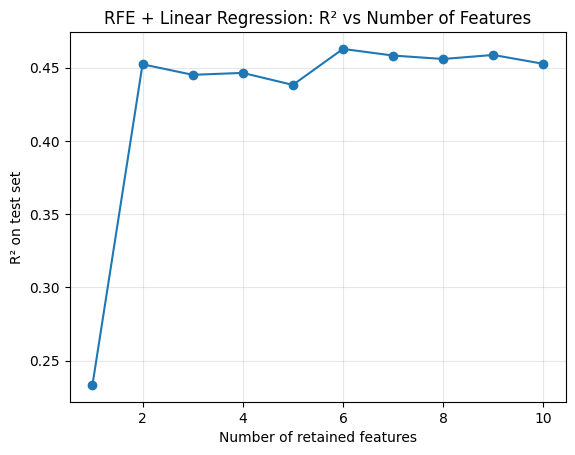

In [4]:
# Task 3.4: Plot R² vs number of features
plt.figure()
plt.plot(results_df["num_features"], results_df["r2"], marker="o")
plt.xlabel("Number of retained features")
plt.ylabel("R² on test set")
plt.title("RFE + Linear Regression: R² vs Number of Features")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
# Task 3.5: I've tried in this step is to choose optimal k using threshold
threshold = 0.01
best_idx = results_df["r2"].idxmax()
best_k = int(results_df.loc[best_idx, "num_features"])
best_r2 = float(results_df.loc[best_idx, "r2"])

opt_candidates = results_df[results_df["r2"] >= (best_r2 - threshold)]
opt_k = int(opt_candidates["num_features"].min())
opt_features = results_df[results_df["num_features"] == opt_k].iloc[0]["selected_features"]
opt_r2 = float(results_df[results_df["num_features"] == opt_k].iloc[0]["r2"])

print("Best R²:", best_r2, "at k =", best_k)
print("Chosen threshold:", threshold)
print("Optimal k:", opt_k, "with R²:", opt_r2)
print("Selected features:", opt_features)


Best R²: 0.4627767079320302 at k = 6
Chosen threshold: 0.01
Optimal k: 6 with R²: 0.4627767079320302
Selected features: ['sex', 'bmi', 'bp', 's1', 's2', 's5']


In [6]:
# Task 4: Coefficient table per iteration (0 = eliminated)
coef_df_rounded = coef_df.round(3)
coef_df_rounded


,k=10,k=9,k=8,k=7,k=6,k=5,k=4,k=3,k=2,k=1
age,37.904,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
sex,-241.964,-236.650,-233.755,-235.364,-215.267,0.000,0.000,0.000,0.000,0.000
bmi,542.429,542.800,550.744,551.866,557.314,597.893,691.460,737.686,732.109,998.578
bp,347.704,354.211,363.792,362.356,350.179,306.648,0.000,0.000,0.000,0.000
s1,-931.489,-936.351,-947.823,-660.643,-851.516,-655.561,-592.978,-228.340,0.000,0.000
s2,518.062,528.797,541.586,343.348,591.093,409.622,362.950,0.000,0.000,0.000
s3,163.420,167.800,172.251,0.000,0.000,0.000,0.000,0.000,0.000,0.000
s4,275.318,270.397,277.741,185.141,0.000,0.000,0.000,0.000,0.000,0.000
s5,736.199,744.447,761.921,664.775,803.121,728.644,783.169,680.225,562.227,0.000
s6,48.671,53.350,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [7]:
# Task 4.2: Top 3 features by |coef| in baseline model
baseline_coefs = coef_df["k=10"]
top3 = baseline_coefs.abs().sort_values(ascending=False).head(3)
top3


s1     931.488846
s5     736.198859
bmi    542.428759
Name: k=10, dtype: float64

# Task 5 — Reflection 
1) What I learned about RFE: RFE is a wrapper method: it repeatedly trains a model and removes the least
useful feature, trading compute for an interpretable ranking.
2) RFE vs LASSO: LASSO (L1) is an embedded method that can drive coefficients to 0 in one optimization,
while RFE eliminates features iteratively based on model rankings. LASSO is sensitive to l; RFE is sensitive to
the base estimator and ranking stability.
3) Dataset insights: In this dataset split, BMI and blood serum measurements (notably s1/s5) are consistently
predictive of disease progression, while some other variables add little beyond them.
